Iter: 0, Residual: 1.1345e+01, CFL: 0.0255
Iter: 5, Residual: 3.5263e+03, CFL: 27.3021


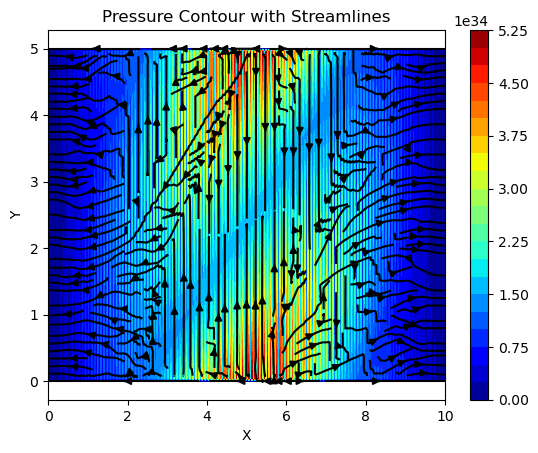

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye, linalg
from scipy.sparse.linalg import spsolve


class Grid:
    def __init__(self, lx, ly, nx, ny):
        self.lx = lx
        self.ly = ly
        self.nx = nx
        self.ny = ny
        self.dx = lx / (nx - 1)
        self.dy = ly / (ny - 1)
        self.x = np.linspace(0, lx, nx)
        self.y = np.linspace(0, ly, ny)

class Solid:
    def __init__(self, x0, y0, angle, length, thickness):
        self.x0 = x0
        self.y0 = y0
        self.angle = np.radians(angle)
        self.length = length
        self.thickness = thickness

    def get_mask(self, grid):
        mask = np.zeros((grid.nx, grid.ny), dtype=bool)
        cos_theta = np.cos(self.angle)
        sin_theta = np.sin(self.angle)
        hl = self.length/2
        ht = self.thickness/2
        
        for i in range(grid.nx):
            for j in range(grid.ny):
                # 坐标变换
                dx = grid.x[i] - self.x0
                dy = grid.y[j] - self.y0
                local_x =  dx*cos_theta + dy*sin_theta
                local_y = -dx*sin_theta + dy*cos_theta
                
                if (-hl <= local_x <= hl) and (-ht <= local_y <= ht):
                    mask[i,j] = True
        return mask

class FluidSolver:
    def __init__(self, grid):
        self.grid = grid
        self.u = np.zeros((grid.nx, grid.ny))
        self.v = np.zeros((grid.nx, grid.ny))
        self.p = np.zeros((grid.nx, grid.ny))
        self.residuals = []

    def apply_velocity_bc(self):
        # 入口边界条件 (左边界)
        self.u[0, :] = 1.0  
        self.v[0, :] = 0.0

        # 出口边界条件 (右边界)
        self.u[-1, :] = self.u[-2, :]
        self.v[-1, :] = self.v[-2, :]

        # 上下壁面：滑移壁面
        self.v[:, 0] = 0.0         # 下边界，垂直速度为0
        self.v[:, -1] = 0.0        # 上边界，垂直速度为0

        self.u[:, 0] = self.u[:, 1]     # 水平方向速度：Neumann边界（∂u/∂y = 0）
        self.u[:, -1] = self.u[:, -2]

    def solve_momentum(self, dt):
        u_star = self.u.copy()
        v_star = self.v.copy()
        dx, dy = self.grid.dx, self.grid.dy

        for i in range(1, self.grid.nx-1):
            for j in range(1, self.grid.ny-1):
                # 压力梯度 (中心差分)
                dpdx = (self.p[i+1,j] - self.p[i-1,j]) / (2*dx)
                dpdy = (self.p[i,j+1] - self.p[i,j-1]) / (2*dy)

                # 对流项（使用一阶上风差分）+ 加负号
                if self.u[i,j] > 0:
                    dudx = (self.u[i,j] - self.u[i-1,j]) / dx
                    dvdx = (self.v[i,j] - self.v[i-1,j]) / dx
                else:
                    dudx = (self.u[i+1,j] - self.u[i,j]) / dx
                    dvdx = (self.v[i+1,j] - self.v[i,j]) / dx

                if self.v[i,j] > 0:
                    dudy = (self.u[i,j] - self.u[i,j-1]) / dy
                    dvdy = (self.v[i,j] - self.v[i,j-1]) / dy
                else:
                    dudy = (self.u[i,j+1] - self.u[i,j]) / dy
                    dvdy = (self.v[i,j+1] - self.v[i,j]) / dy

                conv_u = self.u[i,j] * dudx + self.v[i,j] * dudy
                conv_v = self.u[i,j] * dvdx + self.v[i,j] * dvdy

            # 显式更新（注意是 -conv）
                u_star[i,j] = self.u[i,j] + dt * (-dpdx - conv_u)
                v_star[i,j] = self.v[i,j] + dt * (-dpdy - conv_v)

        self.u, self.v = u_star, v_star



    def build_poisson_matrix(self,nx, ny, dx, dy):
        N = (nx-2) * (ny-2)  # 去掉边界点
        Ix = eye(nx-2)
        Iy = eye(ny-2)
    
        # 1D 二阶差分
        Tx = diags([1, -2, 1], offsets=[-1, 0, 1], shape=(nx-2, nx-2)) / dx**2
        Ty = diags([1, -2, 1], offsets=[-1, 0, 1], shape=(ny-2, ny-2)) / dy**2

        A = kron(Iy, Tx) + kron(Ty, Ix)  # Kronecker product 构造 2D Laplacian
        return A.tocsr()
    
    def build_rhs(self,div_u, dt):
        b = div_u[1:-1, 1:-1].flatten() / dt  # 只取内部点，展平成向量
        return b


    def solve_pressure_correction(self, dt):
        dx, dy = self.grid.dx, self.grid.dy
        nx, ny = self.grid.nx, self.grid.ny
    
        # Step 1: 计算散度
        div_u = np.zeros_like(self.p)
        div_u[1:-1, 1:-1] = (self.u[2:,1:-1] - self.u[:-2,1:-1])/(2*dx) + \
                        (self.v[1:-1,2:] - self.v[1:-1,:-2])/(2*dy)
    
        # Step 2: 构建线性系统
        A = self.build_poisson_matrix(nx, ny, dx, dy)
        b = self.build_rhs(div_u, dt)

        # Step 3: 求解
        p_vec = spsolve(A, b)

        # Step 4: 还原
        p_corr = np.zeros_like(self.p)
        p_corr[1:-1,1:-1] = p_vec.reshape((nx-2, ny-2))
        return p_corr

    def correct_fields(self, p_corr, dt):
        dx, dy = self.grid.dx, self.grid.dy
        # 压力修正
        self.p += p_corr
        
        # 速度修正
        self.u[1:-1,1:-1] -= dt * (p_corr[2:,1:-1] - p_corr[:-2,1:-1]) / (2*dx)
        self.v[1:-1,1:-1] -= dt * (p_corr[1:-1,2:] - p_corr[1:-1,:-2]) / (2*dy)
    
    def compute_cfl(self, dt):
        dx, dy = self.grid.dx, self.grid.dy
        cfl_u = np.max(np.abs(self.u)) * dt / dx
        cfl_v = np.max(np.abs(self.v)) * dt / dy
        return max(cfl_u, cfl_v)


class IBM:
    def __init__(self, grid, solid):
        self.grid = grid
        self.solid = solid
        
    def enforce_boundary(self, u, v):
        mask = self.solid.get_mask(self.grid)
        u[mask] = 0.0  # 无滑移边界
        v[mask] = 0.0
        return u, v

# 主程序
def main():
    # 创建计算域
    grid = Grid(lx=10.0, ly=5.0, nx=256, ny=128)
    solid = Solid(x0=5.0, y0=2.5, angle=30, length=1.0, thickness=0.1)
    solver = FluidSolver(grid)
    ibm = IBM(grid, solid)
    
    # 模拟参数
    dt = 0.001
    max_iter = 10
    
    # 主循环
    for iter in range(max_iter):
        # 边界条件
        solver.apply_velocity_bc()
        
        # 动量预测
        solver.solve_momentum(dt)
        
        # 压力修正
        p_corr = solver.solve_pressure_correction(dt)
        
        # 场修正
        solver.correct_fields(p_corr, dt)
        
        # IBM处理
        #solver.u, solver.v = ibm.enforce_boundary(solver.u, solver.v)
        
        # 残差监测
        if iter % 5 == 0:
            residual = np.linalg.norm(solver.u)
            cfl = solver.compute_cfl(dt)
            solver.residuals.append(residual)
            print(f"Iter: {iter}, Residual: {residual:.4e}, CFL: {cfl:.4f}")

    
    X, Y = np.meshgrid(grid.x, grid.y, indexing='xy')
    plt.contourf(X, Y, solver.p.T, levels=20, cmap='jet')
    plt.colorbar()
    plt.streamplot(X, Y, solver.u.T, solver.v.T, color='k', density=1.5)
    plt.title('Pressure Contour with Streamlines')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

if __name__ == "__main__":
    main()

